In [2]:
%matplotlib inline
import numpy as np
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import pandas as pd
import dask
import os.path
import sh
from __future__ import division
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.rcParams['contour.negative_linestyle']= 'dashed'
plt.rcParams['image.cmap'] = 'RdBu'

from progress_bar import *
from useful import *

global data_dir
data_dir = '/scratch/ap587/dry_data/'

plot_dir = '/scratch/ap587/plots/poster1/'
mkdir = sh.mkdir.bake('-p')
mkdir(plot_dir)

In [71]:
# eddy momentum flux and ITCZ laitude

exp = 'exp9v1'
exps = []
hcs = [10]#, 30, 70] #np.arange(10,91,20)
obls = [10, 30, 70] #np.arange(0,91,15)
for hc in hcs:
    if hc==10:
        obls = [15, 30, 60]
    else:
        obls = [10,30,70]
    for obl in obls:
        exps.append(exp+'_hc{:.1f}-obl{:.1f}'.format(hc, obl))

        
itcz_lat = []
desc_lat = []
max_emf = []
max_emf_div = []
max_emf_div2 = []
zero_emf_div = []
edges = np.zeros((len(hcs)*len(obls)*72, 3))
for i, exp in enumerate(exps):
    print(exp)
    
    ds = open_climatology(data_dir, exp)
    if 'quintad' in ds.keys():
        ds.rename({'quintad':'pentad'}, inplace=True)
    for t in range(ds.pentad.size):
        print(t)
        da = ds.isel(pentad=t)
        itcz_lat.append(calc_itcz_lat(da))
        desc_lat.append(calc_descending_branch(da))
        edges[i*72+t, :] = calc_hc_edges(da, threshold=0.1*np.max(np.abs(da.psi.values)))
        emf_div = (da.uv_dy+da.uw_dp).isel(pfull=slice(6,16)).mean('pfull')
        emf = (da.uv+da.uw).isel(pfull=slice(6,16)).mean('pfull')
        emf_i = np.argmax(np.abs(emf.isel(lat=slice(2,-2)).values)) + 2
        
        idx = (np.abs(da.lat.values-desc_lat[-1])).argmin()
        if desc_lat[-1] <= 0:
            latslice = slice(1,idx)
            emf_div_i2 = np.argmax(((da.uv_dy).isel(pfull=slice(6,16)).mean('pfull').isel(lat=latslice).values)) + 1
        else:
            latslice = slice(idx,-1)
            emf_div_i2 = np.argmax(((da.uv_dy).isel(pfull=slice(6,16)).mean('pfull').isel(lat=latslice).values)) + idx
        emf_div_i = np.argmax(np.abs(emf_div.isel(lat=slice(2,-2)).values)) + 2
        
        idx = (np.abs(da.lat.values-itcz_lat[-1])).argmin()
        if itcz_lat[-1] >= 0:    
            latslice = slice(1,idx-5)
            zed = calc_roots(da.lat.isel(lat=latslice).values, emf_div.isel(lat=latslice).values)
            zi = -1            
        else:
            latslice = slice(idx+5,-1)
            zed = calc_roots(da.lat.isel(lat=latslice).values, emf_div.isel(lat=latslice).values)
            zi = 0
        if zed:
            zed = zed[zi]
        else:
            zed = None
        zero_emf_div.append(zed)
        
        max_emf.append(da.lat.isel(lat=emf_i))
        max_emf_div.append(da.lat.isel(lat=emf_div_i))
        max_emf_div2.append(da.lat.isel(lat=emf_div_i2))
        
desc = []
for edge in edges:
    if edge[1] < 0:
        desc.append(edge[2])
    else:
        desc.append(edge[0])

exp9v1_hc10.0-obl15.0
0
1
No ITCZ found, returning nan
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
No ITCZ found, returning nan
66
67
No ITCZ found, returning nan
68
69
70
71
exp9v1_hc10.0-obl30.0
0
1
2
3
4
5
6
No ITCZ found, returning nan
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
No ITCZ found, returning nan
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
exp9v1_hc10.0-obl60.0
0
1
2
3
4
5
No ITCZ found, returning nan
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
No ITCZ found, returning nan
37
38
39
40
No ITCZ found, returning nan
41
No ITCZ found, returning nan
42
43
44
No ITCZ found, returning nan
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


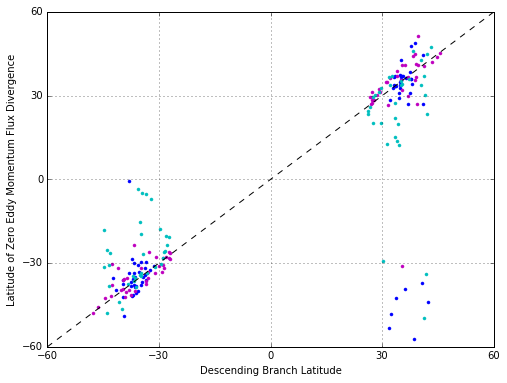

In [106]:
x = (np.array((desc_lat)))
y = (np.array(max_emf_div2))

x = np.array(desc)
y = np.array(zero_emf_div)


seasons = [0,1,2,3]
colors = ['b', 'm', 'c', 'r']
markers = ['.', '*', 'o', '>', 'v', '^', 's', '+', 'x']
fig, ax = plt.subplots(1,1, figsize=(8,6))

for i in range(0, len(exps)):
    for season in seasons:
        if i in [0,1,2]:
            hci = 0
        elif i in [3,4,5]:
            hci = 1
        else:
            hci = 2
        if i in [0,3,6]:
            obli = 0
        elif i in [1,4,7]:
            obli = 1
        else:
            obli = 2
        si = np.arange(72*i + season*18, 72*i + season*18+18)
        si = si.astype(int)
        #ax.plot((x[si]), (y[si]),marker=markers[i], linestyle='', color=colors[season], label='exps[i]'+' season ' + str(season))
        ax.plot((x[si]), (y[si]),marker='.', linestyle='', color=colors[obli], label='exps[i]'+' season ' + str(season))
        #ax.plot((x[si]), (y[si]),marker=markers[i], linestyle='', color='b', label='exps[i]'+' season ' + str(season))
plt.xlabel('Descending Branch Latitude')
plt.ylabel('Latitude of Zero Eddy Momentum Flux Divergence')

ax.set_xticks(np.arange(-60,61,30))
ax.set_yticks(np.arange(-90,91,30))
ax.plot((-60,60), (-60,60), 'k--')
#ax.plot((-30,30), (-60,60), 'k--')
ax.set_ylim([-60,60])
ax.set_xlim([-60,60])
plt.grid()

#plt.savefig(plot_dir + 'fig3-emf1.png', dpi=200,bbox_inches='tight',transparent=True)

In [99]:
print itcz_lat

-10.2507043171


In [ ]:
# -- draft for zero emf divergence code ---


exp = 'exp9v1_hc10.0-obl30.0'
ds = open_climatology(data_dir, exp)
ds.rename({'quintad':'pentad'}, inplace=True)

t = 71

da = ds.isel(pentad=t)
itcz_latz = calc_itcz_lat(da)
emf_div = (da.uv_dy+da.uw_dp).isel(pfull=slice(6,16)).mean('pfull')


r = calc_roots(da.lat.values, emf_div.values, do_plot=1)

print(itcz_latz)
idx = (np.abs(da.lat.values-itcz_latz)).argmin()
if itcz_lat >= 0:    
    latslice = slice(1,idx-5)
    zed = calc_roots(da.lat.isel(lat=latslice).values, emf_div.isel(lat=latslice).values, do_plot=1)
    if len(zed) > 1:
        zed = zed[-1]
else:
    latslice = slice(idx+5,-1)
    zed = calc_roots(da.lat.isel(lat=latslice).values, emf_div.isel(lat=latslice).values, do_plot=1)
    if len(zed) > 1:
        zed = zed[0]
print zed[0]

exp9v1_hc30.0-obl30.0
(-24.055688954505371, array(51.625733674938246), array(-40.46364817811504))


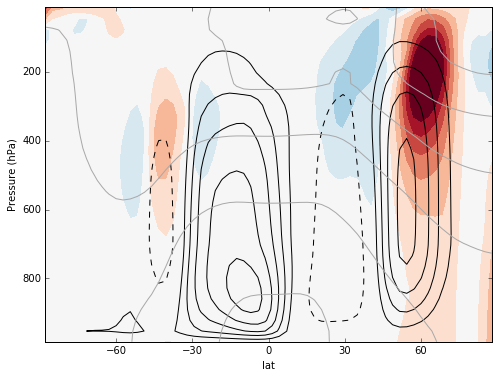

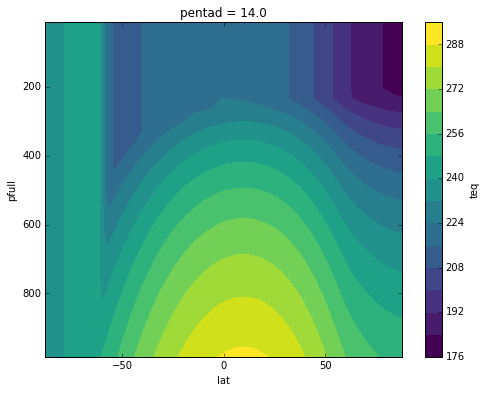

In [89]:
exp = 'exp9v1_hc30.0-obl30.0'
print exp
ds = open_climatology(data_dir, exp)

if 'quintad' in ds.keys():
    ds.rename({'quintad':'pentad'}, inplace=True)

t = 14
data = ds.isel(pentad=t)
db = calc_descending_branch(data)
emfmi = np.argmax(np.abs((data.uv).isel(pfull=slice(6,16)).mean('pfull').values))
emf = data.lat.isel(lat=emfmi).values

wemf = data.uv*np.cos(data.lat)
#wemf_dy = 

idx = (np.abs(data.lat.values-db)).argmin()
if db <= 0:    
    latslice = slice(1,idx)
    emfmi = np.argmax(((data.uv_dy).isel(pfull=slice(6,16)).mean('pfull').isel(lat=latslice).values)) + 1
else:
    latslice = slice(idx,-1)
    emfmi = np.argmax(((data.uv_dy).isel(pfull=slice(6,16)).mean('pfull').isel(lat=latslice).values)) + idx
    
#emfmi = np.argmax(np.abs((data.uv_dy).isel(pfull=slice(6,16)).mean('pfull').isel(lat=slice(2,-2)).values)) + 2
emfdiv = data.lat.isel(lat=emfmi).values
print(db, emf, emfdiv)

x = data.lat.values
y = data.pfull.values
X,Y = np.meshgrid(x,y)

levels = np.linspace(-5,5,12)
psi_levels = [-1e20,-15e10, -12e10, -9e10, -6e10,-5e10, -4e10, -3e10, -2e10, -1e10, 1e10, 2e10, 3e10, 4e10,5e10, 6e10, 9e10, 12e10, 15e10,1e20]


fig, ax = plt.subplots(figsize=(8,6))
#ax.contourf(X, Y, (data.uv+data.uw))
(data.uv_dy).plot.contourf(x='lat', y='pfull', levels=levels, add_colorbar=None, robust=True, extend='both')
ax.contour(X, Y, data.psi, levels = psi_levels, colors='k')
ax.contour(X, Y, data.temp, colors='#a9a9a9')
#data.uv.sel(pfull=500,method='nearest').plot(color='k')
#ax.axvline(db, color='b', linewidth=2)
#ax.axvline(emf, color='r', linewidth=2)
#ax.axvline(emfdiv, color='m', linewidth=2)
ax.invert_yaxis()
ax.set_title('')
ax.set_label('Latitude')
ax.set_xticks(np.arange(-60,61,30))
ax.set_ylabel('Pressure (hPa)')

plt.savefig(plot_dir + 'fig4-d14.png', dpi=200,bbox_inches='tight',transparent=True)


fig, ax = plt.subplots()
data.teq.plot.contourf(x='lat', y='pfull', levels=15)
ax.invert_yaxis()

In [68]:
data.uv_dy.min()

<xarray.DataArray 'uv_dy' ()>
array(-4.2361500152565466)
Coordinates:
    pentad   float64 68.0

In [58]:
data.pfull.isel(pfull=slice(6,16))

<xarray.DataArray 'pfull' (pfull: 10)>
array([ 202.92442198,  234.20122137,  265.4716987 ,  296.73785623,
        328.00093108,  359.26172895,  390.5207972 ,  421.7785207 ,
        453.035178  ,  484.29097567])
Coordinates:
    quintad  float64 65.0
  * pfull    (pfull) float64 202.9 234.2 265.5 296.7 328.0 359.3 390.5 421.8 ...
    h        (pfull) float64 1.151e+04 1.047e+04 9.569e+03 8.766e+03 ...
Attributes:
    units: hPa
    long_name: approx full pressure level
    cartesian_axis: Z
    positive: down

In [47]:
ds

<xarray.Dataset>
Dimensions:      (lat: 64, latb: 65, lonb: 129, pfull: 32, phalf: 33, quintad: 72, time: 72)
Coordinates:
  * latb         (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 -75.36 ...
  * lonb         (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 15.47 ...
  * phalf        (phalf) float64 0.0 31.25 62.5 93.75 125.0 156.2 187.5 ...
  * quintad      (quintad) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * pfull        (pfull) float64 11.5 45.98 77.6 109.0 140.3 171.6 202.9 ...
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
    h            (pfull) float64 3.066e+04 2.114e+04 1.755e+04 1.522e+04 ...
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    ucomp        (quintad, pfull, lat) float64 -14.49 -33.09 -51.35 -68.78 ...
    uw_dp        (quintad, pfull, lat) float64 -0.06891 -0.1969 -0.1709 ...
    vcomp        (quintad, pfull, lat) float64 0.04602 0.1079 0.1652 0.2039 ...
    

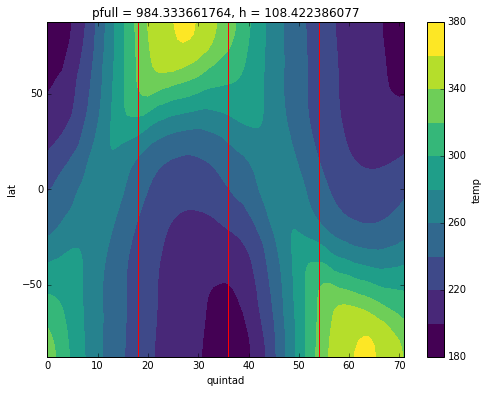

In [34]:
ds.temp.isel(pfull=-1).plot.contourf(x='quintad',y='lat',levels=10)
plt.gca().axvline(18, color='r')
plt.gca().axvline(36, color='r')
plt.gca().axvline(54, color='r')

In [22]:
len(x)/72

7.0

No ITCZ found, returning nan


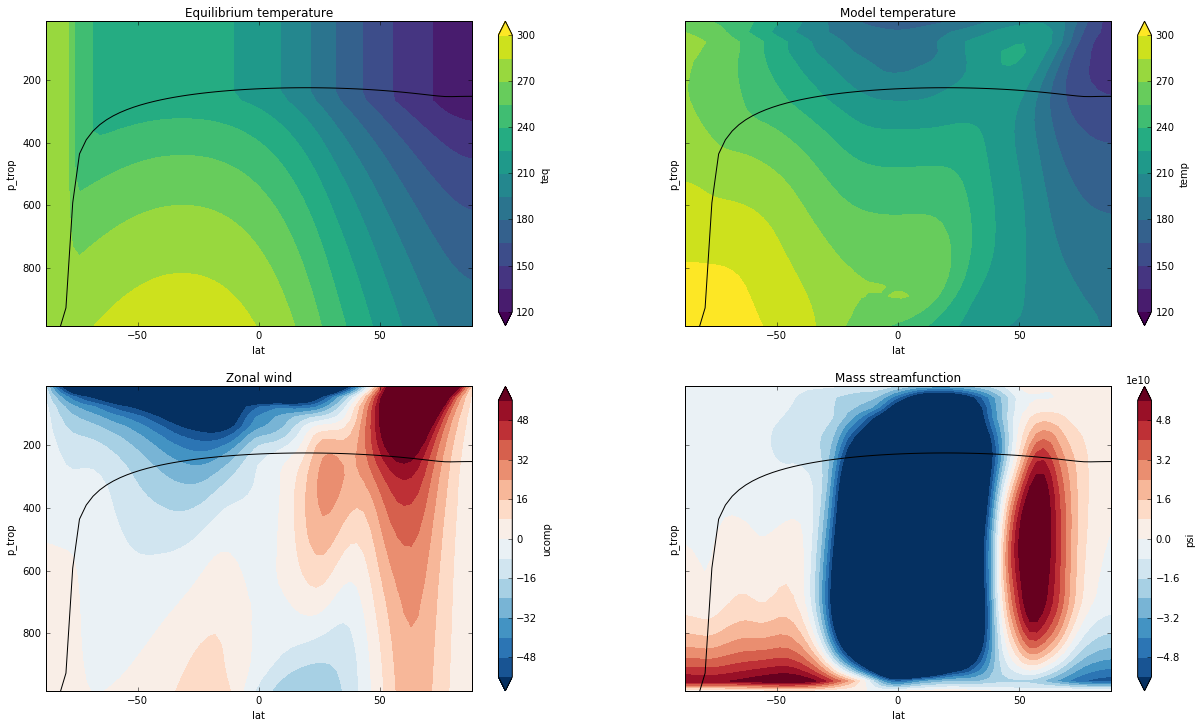

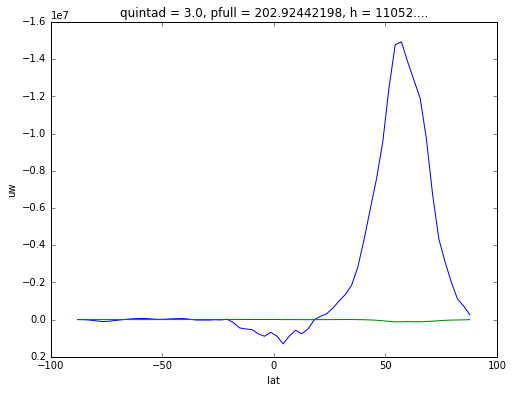

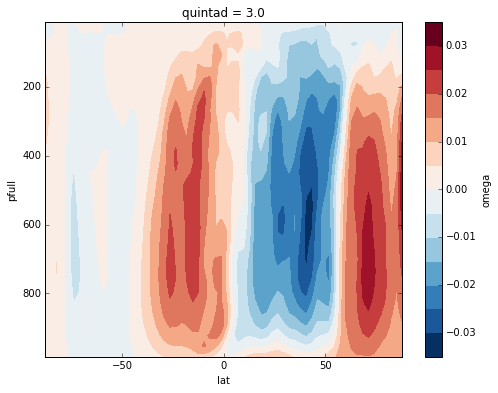

In [67]:
exp = 'exp9v1_hc10.0-obl60.0'

t = 3

ds = open_climatology(data_dir,exp)
plot_grid(ds.isel(quintad=t), do_tp=0)

da = ds.isel(quintad=t)
#edges = get_hc_edges(da)
itcz = calc_itcz_lat(da)
fig, ax = plt.subplots()
da.uv.sel(pfull=200, method='nearest').plot()
da.uw.sel(pfull=200, method='nearest').plot()
#[ax.axvline(edge) for edge in edges]
ax.axvline(itcz, color='m')
ax.invert_yaxis()

fig, ax = plt.subplots()
(-da.omega).plot.contourf(x='lat',y='pfull', levels=15)
ax.invert_yaxis()

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
[array(253.2895334903858), array(257.319808124437), array(261.7636769901512), array(264.3473299096683), array(266.83337090035934), array(268.2360426592158), array(268.9377084564918), array(269.0973809601704), array(269.04830015630426), array(269.00593791375695)]


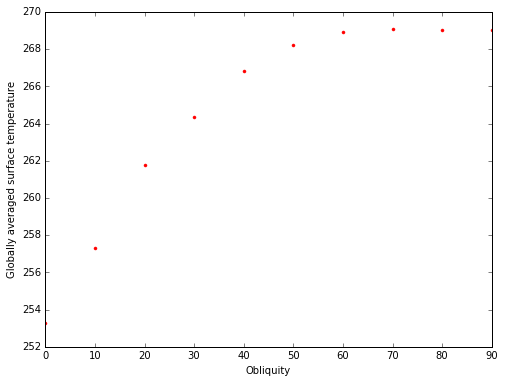

In [12]:
# Globally Averaged Surface Temperature
e = 'exp9'
exps = get_exps(data_dir+'processed/',e)

hc = 20.0
tmp = []
obls = []

for exp in exps:
    if 'hc{:.1f}'.format(hc) in exp:
        tmp.append(exp)
        obls.append(float(exp[15:]))
obls.sort()
tmp.sort()
exps = tmp

surf_temp = []
for exp in exps:
    ds = open_zmean_runset(data_dir, exp)
    ds = ds.isel(time=slice(720,None))
    
    surf_temp.append(ds.temp.isel(pfull=-1).mean('time').mean('lat').values)
    
print obls
print surf_temp

fig, ax = plt.subplots()
ax.plot(obls, surf_temp, 'r.')
ax.set_xlabel('Obliquity')
ax.set_ylabel('Globally averaged surface temperature')

In [10]:
exp = 'exp9v1_hc30.0-obl30.0'
ds = open_climatology(data_dir,exp)
ds

<xarray.Dataset>
Dimensions:      (d5: 72, lat: 64, latb: 65, lonb: 129, pfull: 32, phalf: 33, time: 72)
Coordinates:
  * latb         (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 -75.36 ...
  * d5           (d5) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * lonb         (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 15.47 ...
  * phalf        (phalf) float64 0.0 31.25 62.5 93.75 125.0 156.2 187.5 ...
  * pfull        (pfull) float64 11.5 45.98 77.6 109.0 140.3 171.6 202.9 ...
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
    h            (pfull) float64 3.104e+04 2.14e+04 1.777e+04 1.54e+04 ...
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    ucomp        (d5, pfull, lat) float64 -1.034 -1.931 -2.036 -1.327 0.1211 ...
    uw_dp        (d5, pfull, lat) float64 -0.002523 -0.0007553 0.000347 ...
    vcomp        (d5, pfull, lat) float64 0.0286 0.04586 0.04323 0.03825 ...
    height  

In [5]:
def add_times(ds):
    ds.time.data = ds.time.data/24 - 1
    ds.coords['day'] = ds.time%360
    lag = calc_seasonal_lag(ds.teq.mean('lon'))
    if np.isnan(lag):
        lag = 0   
    ds.coords['day0'] = (ds.day-lag+45)%360
    ds.coords['season'] = np.floor(ds.day0/90)
    ds.coords['s5'] = (np.arange(0,360,5)-lag+45)%360
    ds.coords['d5'] = np.floor(ds.day/5)
    return ds

exp = 'exp9v1_hc30.0-obl30.0'
ds = open_runset(data_dir, exp, runs=range(9,100))
ds = add_times(ds)
ds = ds.mean('lon')
lag = calc_seasonal_lag(ds.teq)
ds.coords['s5'] = np.floor((np.arange(0,360,5)-lag+45)%360/90)
print(ds)
print(ds.groupby('d5').mean('time'))

<xarray.Dataset>
Dimensions:      (lat: 64, latb: 65, lonb: 129, pfull: 32, phalf: 33, s5: 72, time: 1080)
Coordinates:
  * phalf        (phalf) float64 0.0 31.25 62.5 93.75 125.0 156.2 187.5 ...
  * latb         (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 -75.36 ...
  * lonb         (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 15.47 ...
  * pfull        (pfull) float64 11.5 45.98 77.6 109.0 140.3 171.6 202.9 ...
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * time         (time) float64 720.0 721.0 722.0 723.0 724.0 725.0 726.0 ...
    day          (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
    day0         (time) float64 339.0 340.0 341.0 342.0 343.0 344.0 345.0 ...
    season       (time) float64 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 ...
  * s5           (s5) float64 3.0 3.0 3.0 3.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    d5           (time) float64 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 2.0 ...
Data variables:
    

In [6]:
da = ds.groupby('d5').mean('time')

In [7]:
print(da.groupby('s5').mean('d5'))

<xarray.Dataset>
Dimensions:      (lat: 64, latb: 65, lonb: 129, pfull: 32, phalf: 33, s5: 72)
Coordinates:
  * phalf        (phalf) float64 0.0 31.25 62.5 93.75 125.0 156.2 187.5 ...
  * latb         (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 -75.36 ...
  * lonb         (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 15.47 ...
  * pfull        (pfull) float64 11.5 45.98 77.6 109.0 140.3 171.6 202.9 ...
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * s5           (s5) float64 3.0 3.0 3.0 3.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Data variables:
    ucomp        (s5, pfull, lat) float64 -1.85 -3.942 -5.341 -5.688 -4.713 ...
    h_trop       (s5, lat) float64 5.127 5.317 5.542 5.781 6.033 6.299 6.589 ...
    temp         (s5, pfull, lat) float64 200.9 200.9 201.0 201.1 201.3 ...
    ucomp_sq     (s5, pfull, lat) float64 172.3 278.6 445.4 638.6 826.8 ...
    ps           (s5, lat) float64 9.85e+04 9.852e+04 9.855e+04 9.859e+04 ...
    vcomp        (s5, 

In [8]:
print(da.groupby('s5').mean('d5').temp.shape)

(72, 32, 64)


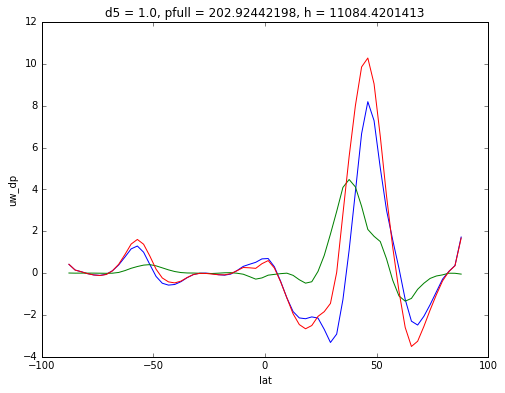

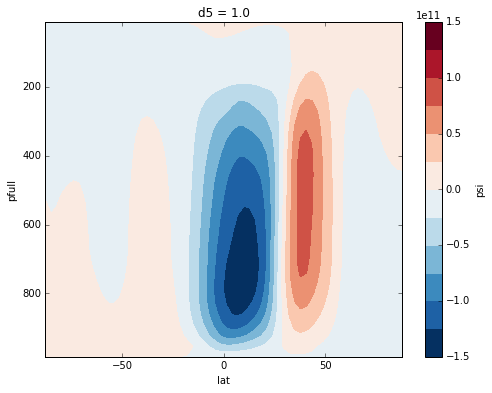

In [9]:
ds.uv_dy.isel(d5=1).sel(pfull=200, method='nearest').plot()
ds.uw_dp.isel(d5=1).sel(pfull=200, method='nearest').plot()
(ds.uw_dp+ds.uv_dy).sel(pfull=200, method='nearest').isel(d5=1).plot()

fig, ax = plt.subplots()
ds.psi.isel(d5=1).plot.contourf(x='lat', y='pfull', levels=15)
ax.invert_yaxis()

(-90, 90)

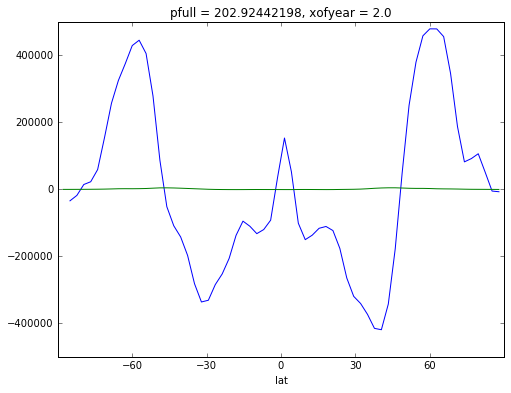

In [14]:
lag = calc_seasonal_lag(ds.teq.mean('lon'))
ds.coords['xofyear'] = np.mod( ds.time-lag+45, 360.) //90 + 1
ds_timeav = ds.groupby('xofyear').mean('time').isel(xofyear=1)

uv = -86400. * (ds_timeav.ucomp_vcomp - ds_timeav.ucomp*ds_timeav.vcomp).sel(pfull=200, method='nearest')
uv_dy = uv.diff('lat', label='upper')

uw = -86400. * (ds_timeav.ucomp_omega - ds_timeav.ucomp*ds_timeav.omega)
uw_dp = uw.diff('pfull', label='upper').sel(pfull=200, method='nearest')

fig, ax = plt.subplots()
uv_dy.mean('lon').plot()
uw_dp.mean('lon').plot()
ax.set_xticks([-60, -30, 0, 30, 60])
ax.set_xlim([-90,90])